In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
import os
from zipfile import ZipFile
import csv
import random
from math import isnan 

In [17]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()
df = pandas.read_csv(dataset)

In [18]:
df.head()

,Unnamed: 0,circle,Experiment-1546_384,Experiment-1546_61,Experiment-1546_51,Experiment-1546_222,Experiment-1546_170,Experiment-1546_65,Experiment-1546_55,Experiment-1546_59,...,Experiment-1547_123,Experiment-1547_318,Experiment-1547_396,Experiment-1547_94,Experiment-1547_126,Experiment-1547_374,Experiment-1547_320,Experiment-1547_406,Experiment-1547_293,Experiment-1547_351
0,0,1,920.731707,383.653846,316.770186,1261.690885,20.869565,1797.752809,737.992832,278.389262,...,534.011091,611.464968,47.300216,728.645833,194.090909,421.862348,494.459834,34.456929,1098.181818,410.708899
1,1,2,697.071742,437.737844,526.421801,1218.336262,6.535948,2165.936255,1065.418895,270.731707,...,634.710744,494.230769,51.201672,753.128555,214.169215,359.561753,635.732430,38.030888,1208.319185,511.904762
2,2,3,735.714286,448.949772,508.200000,1214.770241,4.804560,2156.158484,951.602815,282.629610,...,615.044814,469.969666,60.258964,750.096525,232.073814,338.941891,612.331839,54.233026,1231.409396,503.281853
3,3,4,742.126379,475.000000,489.196197,1157.303371,4.332130,2054.172989,875.348189,318.654132,...,625.543159,480.366492,75.927688,714.417435,252.586873,315.886416,583.010033,78.888889,1190.354767,483.186878
4,4,5,741.457069,478.149466,483.181126,1125.203252,4.020752,1974.915254,829.692404,335.069124,...,611.206897,463.545664,87.931034,664.592593,281.473829,302.054795,569.309927,99.336430,1088.762984,469.527897


FileNotFoundError: [Errno 2] No such file or directory: '/home/saka/Documents/Lab_stuff/confocal/20230427 thp1lc3 gal3 alix/gal3/plot_gal3.svg'

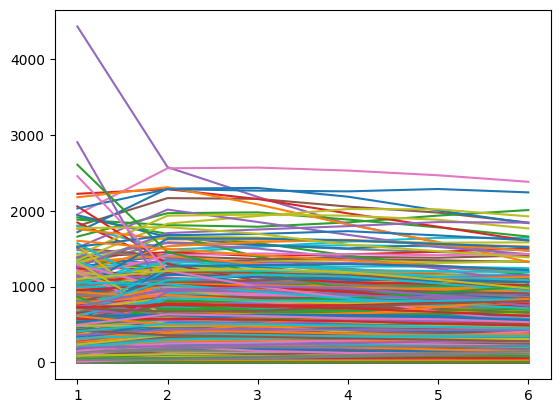

In [44]:
for i in range (2, len(df.columns)):
    plt.plot(df['circle'], df[df.columns[i]])

result = f"/home/saka/Documents/Lab_stuff/confocal/20230427 thp1lc3 gal3 alix/gal3/plot_gal3.svg"
plt.savefig(result)

In [37]:
result = Path(f"/home/saka/Documents/Lab_stuff/confocal/20230427 thp1lc3 gal3 alix/gal3/plot_gal3.svg")
plt.savefig(result)

FileNotFoundError: [Errno 2] No such file or directory: '\\home\\saka\\Documents\\Lab_stuff\\confocal\\20230427 thp1lc3 gal3 alix\\gal3\\plot_gal3.svg'

<Figure size 640x480 with 0 Axes>

In [19]:
df_transposed = df.transpose()

In [20]:
df_transposed.head()

,0,1,2,3,4,5
Unnamed: 0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
circle,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
Experiment-1546_384,920.731707,697.071742,735.714286,742.126379,741.457069,728.015267
Experiment-1546_61,383.653846,437.737844,448.949772,475.000000,478.149466,489.436620
Experiment-1546_51,316.770186,526.421801,508.200000,489.196197,483.181126,474.575119


In [21]:
df_cleaned = df_transposed.drop(["Unnamed: 0","circle"])
df_cleaned.rename(columns={df_cleaned.columns[0]: 'd0', 
                           df_cleaned.columns[1]: 'd1',  
                           df_cleaned.columns[2]: 'd2', 
                           df_cleaned.columns[3]: 'd3', 
                           df_cleaned.columns[4]: 'd4', 
                           df_cleaned.columns[5]: 'd5'}, inplace=True)
df_cleaned.head()

,d0,d1,d2,d3,d4,d5
Experiment-1546_384,920.731707,697.071742,735.714286,742.126379,741.457069,728.015267
Experiment-1546_61,383.653846,437.737844,448.949772,475.000000,478.149466,489.436620
Experiment-1546_51,316.770186,526.421801,508.200000,489.196197,483.181126,474.575119
Experiment-1546_222,1261.690885,1218.336262,1214.770241,1157.303371,1125.203252,1094.275492
Experiment-1546_170,20.869565,6.535948,4.804560,4.332130,4.020752,5.297234


In [28]:
df_norm = df_cleaned.sub(df_cleaned.mean(axis=1), axis=0)
df_norm.head()

,d0,d1,d2,d3,d4,d5,cluster
Experiment-1546_384,268.429357,44.769392,83.411936,89.824029,89.154718,75.712917,-651.302350
Experiment-1546_61,-4.478661,49.605337,60.817265,86.867493,90.016959,101.304113,-384.132507
Experiment-1546_51,-83.564732,126.086882,107.865081,88.861279,82.846208,74.240200,-396.334919
Experiment-1546_222,251.465242,208.110619,204.544597,147.077728,114.977609,84.049849,-1010.225643
Experiment-1546_170,13.603824,-0.729794,-2.461181,-2.933611,-3.244989,-1.968508,-2.265741


In [54]:
df_melted = df_norm.melt(ignore_index=False)

In [55]:
df_melted.head()

,variable,value
Experiment-1546_321,d0,25.367814
Experiment-1546_86,d0,-0.752446
Experiment-1546_71,d0,19.675741
Experiment-1546_4,d0,-0.578733
Experiment-1546_290,d0,51.475209


In [22]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10)

In [31]:
clustering.fit(df_norm)

AgglomerativeClustering(n_clusters=10)

In [32]:
experiment_labels = clustering.labels_

# Print the labels
print(experiment_labels)

[9 7 7 2 4 6 3 4 4 2 2 3 2 4 4 1 9 3 9 2 3 3 4 2 3 4 2 4 9 6 1 7 9 3 4 3 7
 2 3 4 4 7 7 2 1 4 3 1 4 4 9 9 2 4 0 2 1 2 4 3 8 7 2 9 5 1 1 3 7 8 1 3 3 7
 7 3 5 3 2 2 7 3 4 9 3 4 4 8 3 9 9 3 9 4 8 1 1 9 1 7 8 8 1 8 7 4 7 8 3 7 2
 3 2 4 8 8 7 8 7 8 7 8 6 9 8 8 9 5 1 7 4 1 7 1 2 4 1 1 8 8 6 3 1 2 2 3 7 9
 8 1 3 4 8 7 1 7 4 5 8 8 8 4 4 7 4 4 1 4 7 1 7 7 8 8 1 8 8 4 8 8 7 4 7 7 7
 7 6 1 2 8 7 2 7 8 7 8 8 8 1 5 9 2 7 1 7 8 8 4 6 1 2 7 3 1 4 4 7 8 8 8 1 1
 9 8 3 4 4 4 7 4 4 8 7 7 1 5 7 4 4 1 8 1 1 7 2 5 7 1 7 8 1 8 1 4 4 8 7 3 6
 8 1 2 1 0 8 7 8 4 4 9 3 8 8 4 4 4 2 8 7 4 2 4 7 4 1 7 7 7 7 8 7 2 7 7 1 7
 4 4 2 7 9 1 7 4 8 4 1 1 4 5 6 1 8 2 6 4 9 1 7 3 1 1 9 8 7 3 8 8 4 7 4 8 3
 4 3 4 7 4 1 7 7 8 4 4 4 7 8 7 7 4 3 4 8 4 5 4 9 1 9 4 7 4 7 4 4 9 7 4 8 8
 4 4 4 4 8 1 9 4 7 4 8 9 4 4 9 3 9 9 4 7 4 1 4 4 8 4 9 1 4 7 4 3 4 7 4 8 4
 4 7 4 6 9 7 4 4 7 7 7 8 7 1 7 4 1 0 9 4 4 5 4 8 4 4 8 8 8 4 1 4 4 4 7 8 1
 4 8 4 7 4 8 4 4 7 4 1 7 4 1 4 4 4 7 3 1 4 7 1 4 8 4 7 3 8 8 4 4 7 4 8 5 9
 8 8 4 7 7 7 3 5 8 7 9 0 

In [33]:
df_norm['cluster'] = experiment_labels

In [34]:
df_norm.head()

,d0,d1,d2,d3,d4,d5,cluster
Experiment-1546_384,268.429357,44.769392,83.411936,89.824029,89.154718,75.712917,9
Experiment-1546_61,-4.478661,49.605337,60.817265,86.867493,90.016959,101.304113,7
Experiment-1546_51,-83.564732,126.086882,107.865081,88.861279,82.846208,74.240200,7
Experiment-1546_222,251.465242,208.110619,204.544597,147.077728,114.977609,84.049849,2
Experiment-1546_170,13.603824,-0.729794,-2.461181,-2.933611,-3.244989,-1.968508,4


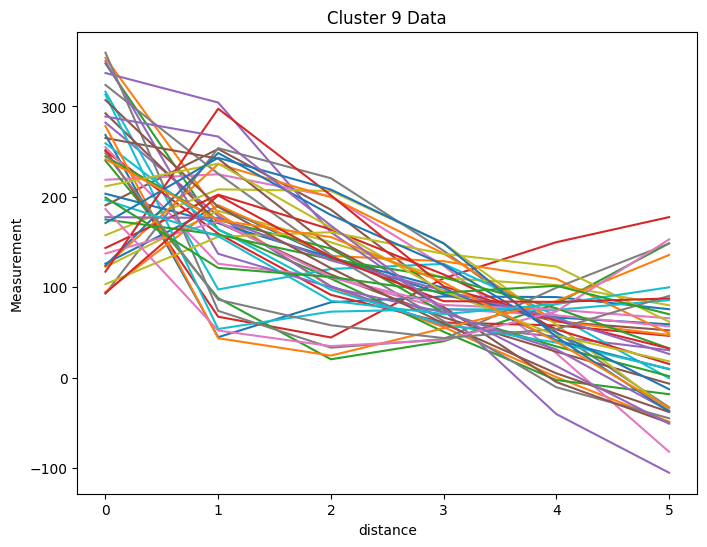

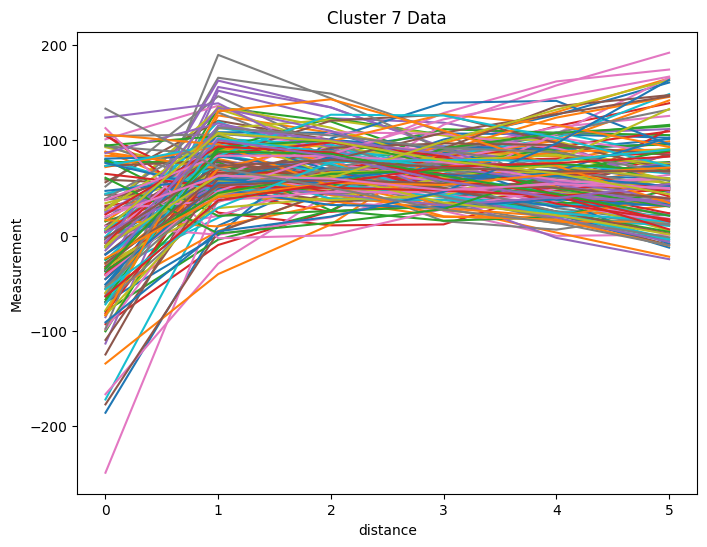

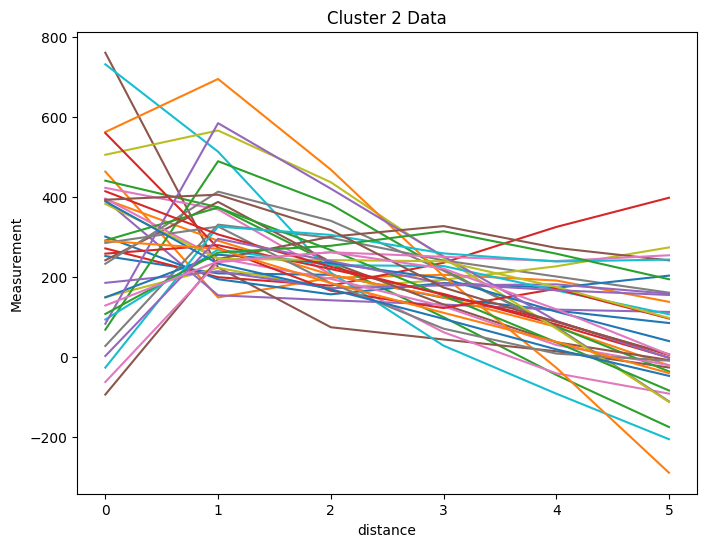

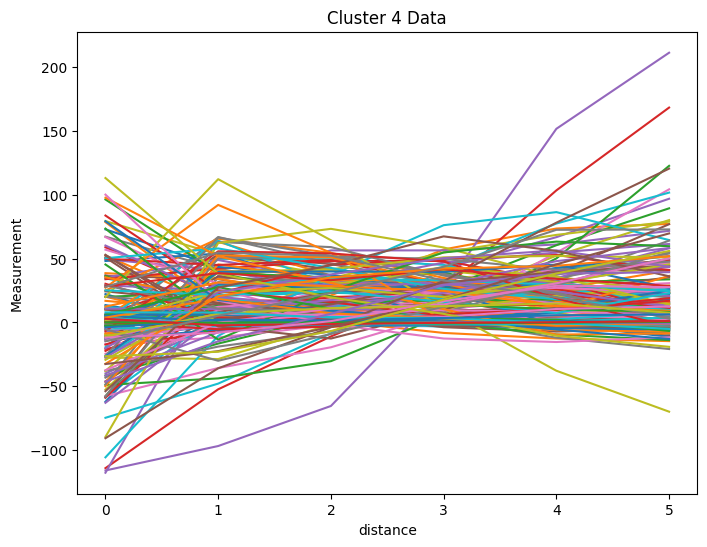

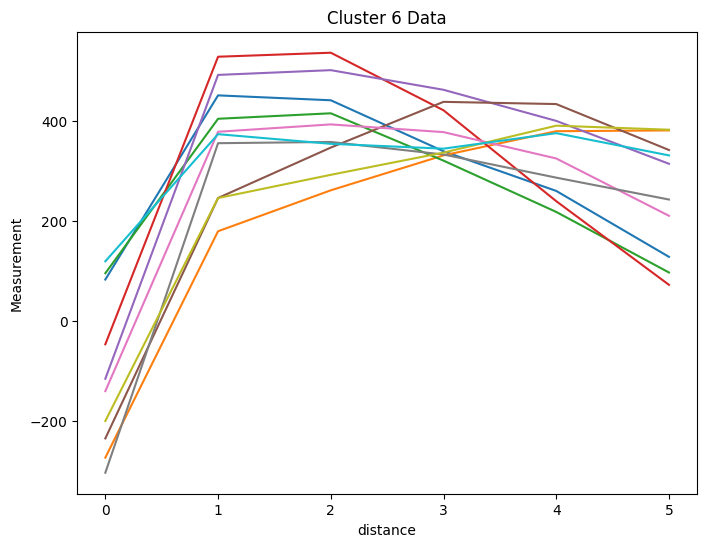

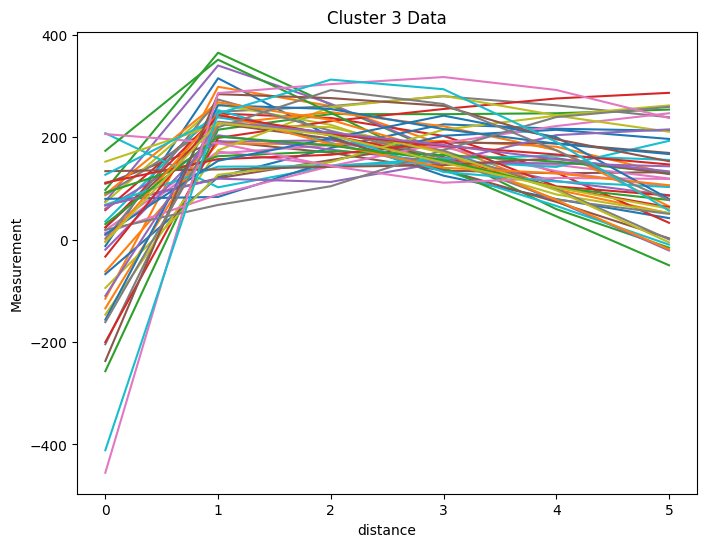

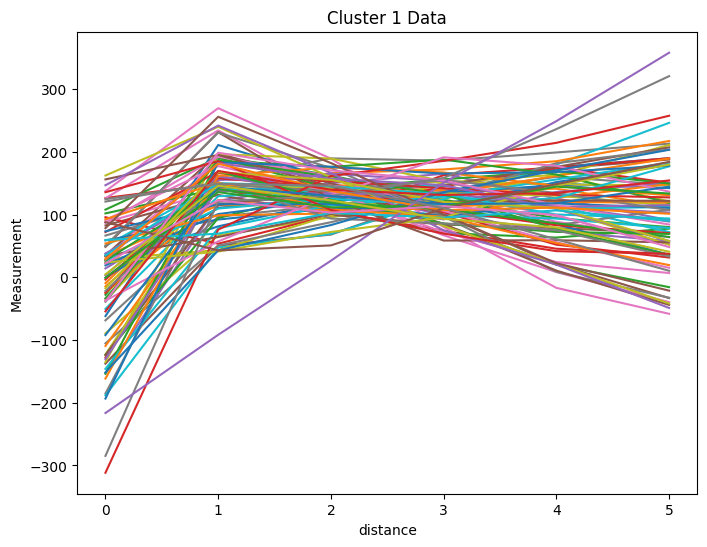

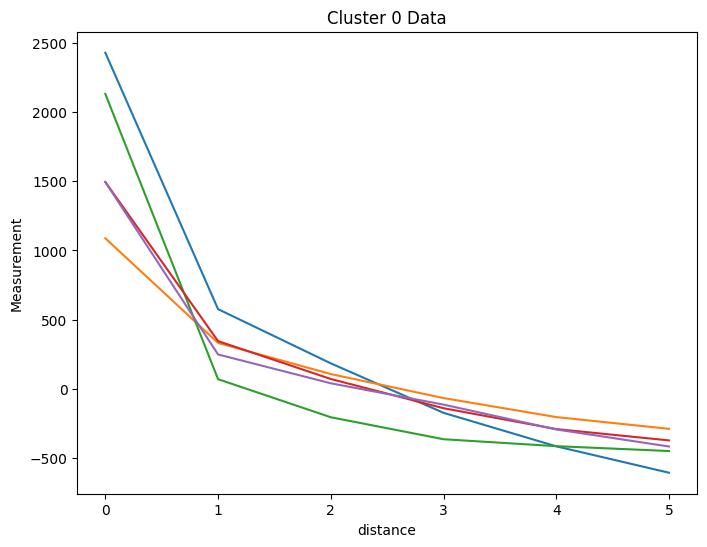

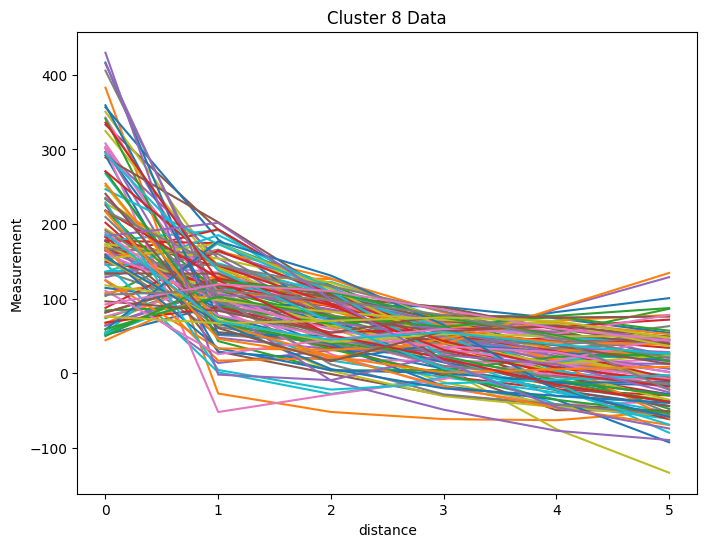

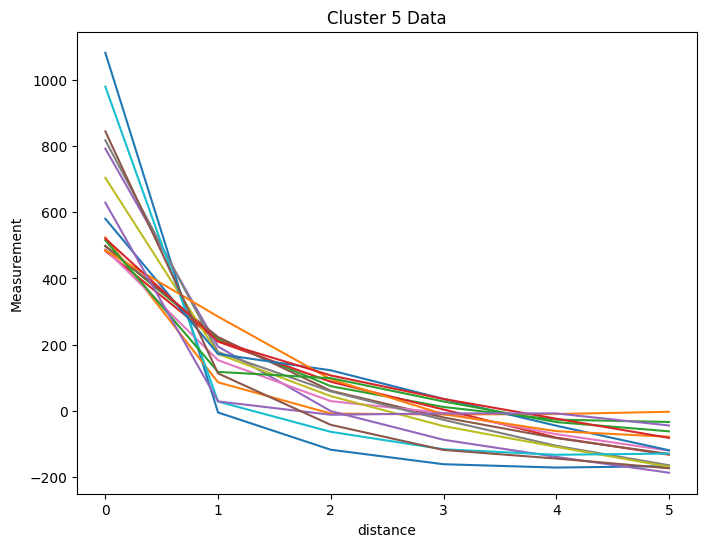

In [35]:
for cluster_num in df_norm['cluster'].unique():
    # Filter data for the current cluster
    cluster_data = df_norm[df_norm['cluster'] == cluster_num]
    
    # Plot the data for the current cluster
    plt.figure(figsize=(8, 6))
    for idx, row in cluster_data.iterrows():
        plt.plot(range(len(row)-1), row[:-1], label=idx)  # Exclude the last column 'cluster' from plotting
    plt.title(f'Cluster {cluster_num} Data')
    plt.xlabel('distance')
    plt.ylabel('Measurement')
    #plt.legend()
    plt.show()